In [1]:
import xgboost as xgb
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [2]:

parent_path = os.path.dirname(os.getcwd())
df = pd.read_csv(os.path.join(parent_path, 'data', 'jena_climate_2009_2016.csv'))

df['Date Time'] = pd.to_datetime(df['Date Time'], format="%d.%m.%Y %H:%M:%S")
df.set_index('Date Time', inplace=True)
df = df.drop_duplicates()
df = df.sort_index()
df = df.resample('h').mean()
df = df.dropna()

start_date = df.index.min()
end_date = df.index.max()
hourly_index = pd.date_range(start=start_date, end=end_date, freq='h')


df = df.reindex(hourly_index)
df = df.interpolate(method='time')


Q1 = df['T (degC)'].quantile(0.25)
Q3 = df['T (degC)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['T (degC)'] = np.where(df['T (degC)'] < lower_bound, lower_bound, df['T (degC)'])
df['T (degC)'] = np.where(df['T (degC)'] > upper_bound, upper_bound, df['T (degC)'])


df["hour"] = df.index.hour
df["dayofyear"] = df.index.dayofyear
df["year"] = df.index.year


In [3]:


lag_hours = 24
for lag in range(1, lag_hours + 1):
    df[f"temp_lag_{lag}"] = df["T (degC)"].shift(lag)

df.dropna(inplace=True)


In [4]:

features = ["T (degC)", "p (mbar)", "rh (%)", "wv (m/s)", "wd (deg)", "hour", "dayofyear"]
target = "T (degC)"
lag_features = [col for col in df.columns if "temp_lag_" in col]

X = df[lag_features + ["hour", "dayofyear"]]  
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=24 * 365, shuffle=False)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:

print("\nModel Selection and Hyperparameter Tuning (XGBoost):")
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500], 
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2], 
    'max_depth': [2, 3, 4, 5, 6, 7] 
}
tscv = TimeSeriesSplit(n_splits=3) 
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=701) 
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', 
                           cv=tscv, verbose=0, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_xgb_model = grid_search.best_estimator_
print("Best XGBoost model parameters:", grid_search.best_params_)


Model Selection and Hyperparameter Tuning (XGBoost):


c:\Users\rodri.RODRIGO\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best XGBoost model parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}


In [ ]:

print("\nEvaluation of Best XGBoost Model (Direct Forecast):")
y_xgb_pred = best_xgb_model.predict(X_test_scaled)

xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_mae = mean_absolute_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)
print(f"  Mean Squared Error: {xgb_mse:.4f}")
print(f"  Mean Absolute Error: {xgb_mae:.4f}")
print(f"  R^2: {xgb_r2:.4f}")


Evaluation of Best XGBoost Model (Direct Forecast):
  Mean Squared Error: 0.3092
  Mean Absolute Error: 0.3878
  R^2: 0.9954


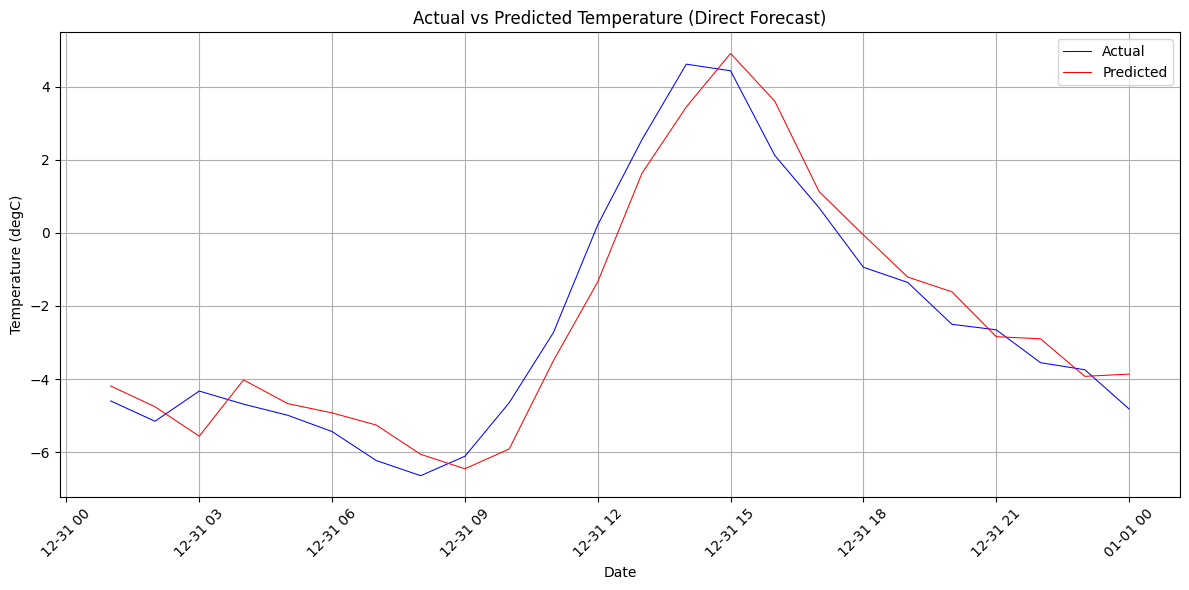

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(y_test.index[-24:], y_test[-24:], color='blue', linewidth=0.75, label="Actual")
plt.plot(y_test.index[-24:], y_xgb_pred[-24:], color='red', linewidth=0.75, label="Predicted")
plt.xlabel("Date")
plt.ylabel("Temperature (degC)")
plt.title("Actual vs Predicted Temperature (Direct Forecast)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:

def recursive_forecast(model, last_obs_scaled, scaler, forecast_hours, X_columns):
    """
    Realiza previsão recursiva para um determinado número de horas.

    Argumentos:
        model: Modelo XGBoost treinado.
        last_obs_scaled: Última observação escalada, do tipo pandas Series.
        scaler: Objeto StandardScaler já ajustado.
        forecast_hours: Número de horas a serem previstas.
        X_columns: Lista dos nomes das features utilizadas no treinamento.

    Retorna:
        pandas.DataFrame: DataFrame contendo as datas das previsões e as temperaturas previstas.
    """
    recursive_preds = []
    forecast_dates = []
    current_time = last_obs_scaled.name  
    
    for i in range(forecast_hours):
        
        current_input = pd.DataFrame([last_obs_scaled.values], columns=X_columns)

        
        y_pred = model.predict(current_input)[0]
        
       
        forecast_time = current_time + pd.Timedelta(hours=1)
        recursive_preds.append(y_pred)
        forecast_dates.append(forecast_time)

        
        for lag in range(lag_hours, 1, -1):
            last_obs_scaled[f"temp_lag_{lag}"] = last_obs_scaled[f"temp_lag_{lag - 1}"]
        last_obs_scaled[f"temp_lag_1"] = (y_pred - scaler.mean_[0]) / scaler.scale_[0] # Scale the predicted value

        
        last_obs_scaled["hour"] = (forecast_time.hour - scaler.mean_[0]) / scaler.scale_[0]
        last_obs_scaled["dayofyear"] = (forecast_time.dayofyear - scaler.mean_[0]) / scaler.scale_[0]
        current_time = forecast_time

    
    forecast_df = pd.DataFrame({'Forecast_Date': forecast_dates, 'Predicted_T (degC)': recursive_preds})
    forecast_df.set_index('Forecast_Date', inplace=True)
    return forecast_df



In [9]:

forecast_hours = 24
last_obs = X_test.iloc[len(X_test)-forecast_hours-1]
last_obs_scaled = pd.Series(scaler.transform(last_obs.to_frame().T).flatten(), index=X.columns, name=last_obs.name) #scaling using the training set


forecast_df = recursive_forecast(best_xgb_model, last_obs_scaled, scaler, forecast_hours, X.columns)


In [10]:


y_actual = y_test[-forecast_hours:]
y_pred = forecast_df['Predicted_T (degC)']

mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("\nRecursive Forecast Metrics:")
print(f"  Mean Absolute Error: {mae:.4f}")
print(f"  Mean Squared Error: {mse:.4f}")
print(f"  R² Score: {r2:.4f}")



Recursive Forecast Metrics:
  Mean Absolute Error: 1.8927
  Mean Squared Error: 5.3061
  R² Score: 0.5070


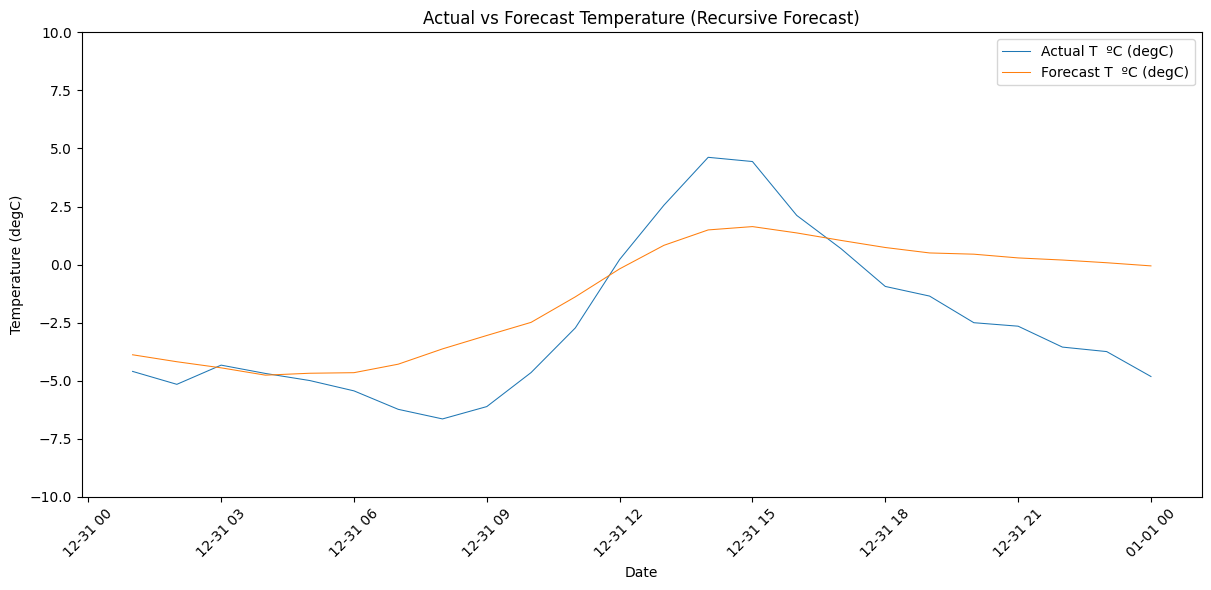

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(y_actual.index, y_actual, linewidth=0.75, label='Actual T  ºC (degC)')
plt.plot(forecast_df.index, forecast_df['Predicted_T (degC)'], linewidth=0.75, label='Forecast T  ºC (degC)')
plt.xlabel("Date")
plt.ylabel("Temperature (degC)")
plt.title("Actual vs Forecast Temperature (Recursive Forecast)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.ylim(-10, 10)
plt.show()

In [12]:

forecast_periods = [24, 48, 72]  
forecast_results = {} 



In [ ]:

print("\nRecursive Forecast for Different Periods:")
for forecast_hour in forecast_periods:
    print(f"\n--- Forecasting for {forecast_hour} hours ---")
    
    
    last_obs = X_test.iloc[-forecast_hour-1] 
    last_obs_scaled = pd.Series(scaler.transform(last_obs.to_frame().T).flatten(), index=X.columns, name=last_obs.name) 
    
    forecast_df = recursive_forecast(best_xgb_model, last_obs_scaled.copy(), scaler, 24, X.columns) 

    y_actual_period = y_test[-forecast_hour:None if forecast_hour == 24 else -forecast_hour+24] 
    y_pred_period = forecast_df['Predicted_T (degC)']

    mae = mean_absolute_error(y_actual_period, y_pred_period)
    mse = mean_squared_error(y_actual_period, y_pred_period)
    r2 = r2_score(y_actual_period, y_pred_period)

    print(f"  {forecast_hour}-hour Forecast Metrics:")
    print(f"    Mean Absolute Error: {mae:.4f}")
    print(f"    Mean Squared Error: {mse:.4f}")
    print(f"    R² Score: {r2:.4f}")

    forecast_results[forecast_hour] = forecast_df 




Recursive Forecast for Different Periods:

--- Forecasting for 24 hours ---
  24-hour Forecast Metrics:
    Mean Absolute Error: 1.8927
    Mean Squared Error: 5.3061
    R² Score: 0.5070

--- Forecasting for 48 hours ---
  48-hour Forecast Metrics:
    Mean Absolute Error: 2.0771
    Mean Squared Error: 5.6833
    R² Score: 0.0229

--- Forecasting for 72 hours ---
  72-hour Forecast Metrics:
    Mean Absolute Error: 1.3903
    Mean Squared Error: 3.7626
    R² Score: -0.1453


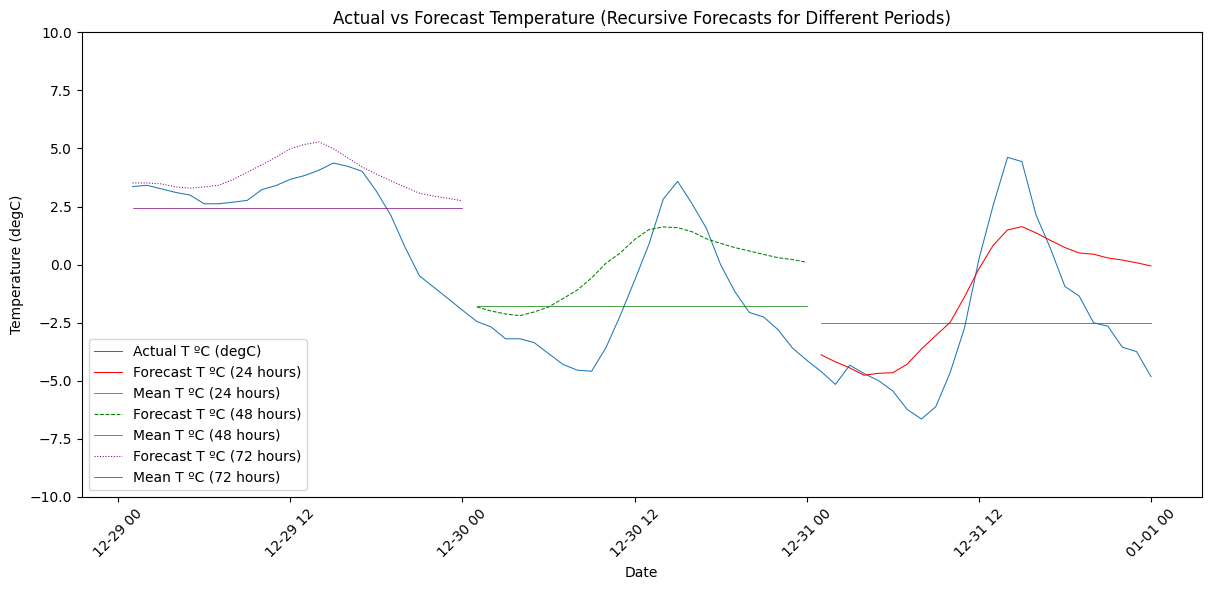

In [15]:


plt.figure(figsize=(12, 6))
plt.plot(y_test.index[-max(forecast_periods):], y_test[-max(forecast_periods):], linewidth=0.75, label='Actual T ºC (degC)') 
colors = ['red', 'green', 'purple']
linestyles = ['-', '--', ':'] 

for i, forecast_hour in enumerate(forecast_periods):
    forecast_df = forecast_results[forecast_hour]
    plt.plot(forecast_df.index, forecast_df['Predicted_T (degC)'], linewidth=0.75, color=colors[i], linestyle=linestyles[i], label=f'Forecast T ºC ({forecast_hour} hours)')
    
    mean_actual = y_test[-forecast_hour:None if forecast_hour == 24 else -forecast_hour+24].mean()
    mean_line = [mean_actual] * len(forecast_df.index)
    plt.plot(forecast_df.index, mean_line, linewidth=0.5, color=colors[i], label=f'Mean T ºC ({forecast_hour} hours)')
    

plt.xlabel("Date")
plt.ylabel("Temperature (degC)")
plt.title("Actual vs Forecast Temperature (Recursive Forecasts for Different Periods)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.ylim(-10, 10)
plt.show()


In [ ]:
for forecast_hour in range(24,31*24-1):
    print(f"\n--- Forecasting for {forecast_hour} hours ---")
    
    
    last_obs = X_test.iloc[-forecast_hour-1] 
    last_obs_scaled = pd.Series(scaler.transform(last_obs.to_frame().T).flatten(), index=X.columns, name=last_obs.name) 
    
    
    forecast_df = recursive_forecast(best_xgb_model, last_obs_scaled.copy(), scaler, 24, X.columns) 

    forecast_results[forecast_hour] = forecast_df 


--- Forecasting for 24 hours ---

--- Forecasting for 25 hours ---

--- Forecasting for 26 hours ---

--- Forecasting for 27 hours ---

--- Forecasting for 28 hours ---

--- Forecasting for 29 hours ---

--- Forecasting for 30 hours ---

--- Forecasting for 31 hours ---

--- Forecasting for 32 hours ---

--- Forecasting for 33 hours ---

--- Forecasting for 34 hours ---

--- Forecasting for 35 hours ---

--- Forecasting for 36 hours ---

--- Forecasting for 37 hours ---

--- Forecasting for 38 hours ---

--- Forecasting for 39 hours ---

--- Forecasting for 40 hours ---

--- Forecasting for 41 hours ---

--- Forecasting for 42 hours ---

--- Forecasting for 43 hours ---

--- Forecasting for 44 hours ---

--- Forecasting for 45 hours ---

--- Forecasting for 46 hours ---

--- Forecasting for 47 hours ---

--- Forecasting for 48 hours ---

--- Forecasting for 49 hours ---

--- Forecasting for 50 hours ---

--- Forecasting for 51 hours ---

--- Forecasting for 52 hours ---

--- Forecasti

In [49]:
all_forecasts_df = pd.concat(forecast_results.values())


grouped = all_forecasts_df.groupby(all_forecasts_df.index)['Predicted_T (degC)']


summary_df = grouped.agg(
    mean='mean',
    lower=lambda x: np.percentile(x, 5),
    upper=lambda x: np.percentile(x, 95)
)


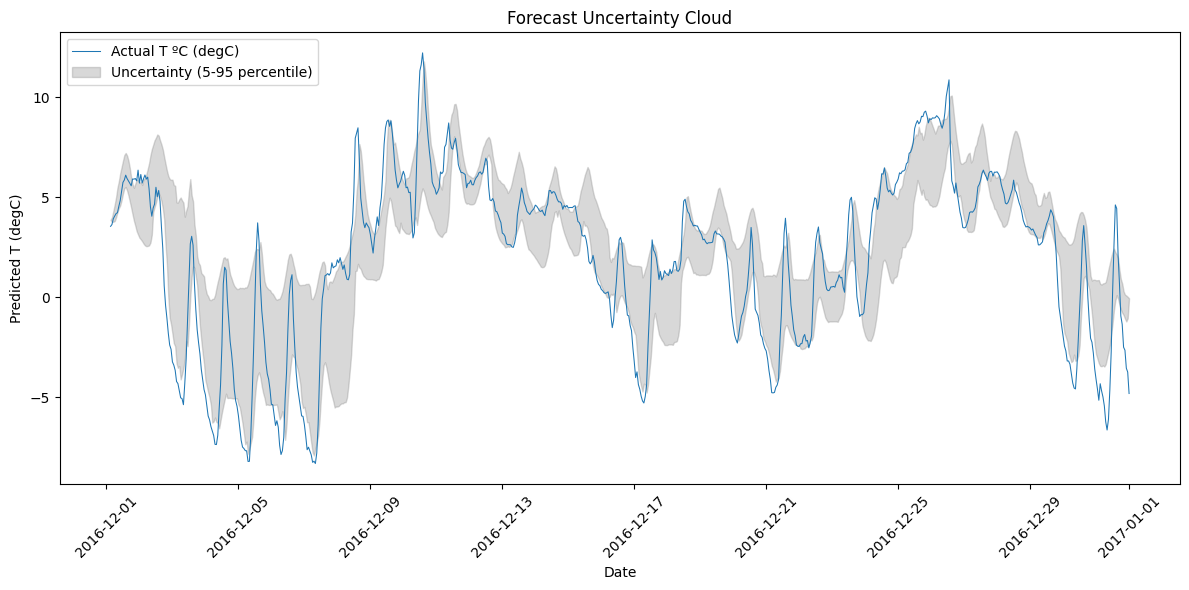

In [52]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.index[-max(range(24,31*24-1)):], y_test[-max(range(24,31*24-1)):], linewidth=0.75, label='Actual T ºC (degC)') # Plot actual for the longest forecast period

plt.fill_between(summary_df.index, summary_df['lower'], summary_df['upper'], color='gray', alpha=0.3, label='Uncertainty (5-95 percentile)')
plt.xlabel("Date")
plt.ylabel("Predicted T (degC)")
plt.title("Forecast Uncertainty Cloud")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [57]:

actual_period = df[-24*31:]  


common_index = summary_df.index.intersection(actual_period.index)
y_true = actual_period.loc[common_index, 'T (degC)']
y_pred = summary_df.loc[common_index, 'mean']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)

MAE: 1.8770009400014143
MSE: 5.440295874714445
R²: 0.7038040993741304
